In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber


In [28]:
CSV_PATH = './../data/GOOGL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 15

# FEATURES = [
#     'Open', 'High', 'Low', 'Close', 'Volume',
#     'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
#     'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
#     'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
# ]

FEATURES = [
    'Close', 'Volume',
    'rsi', 'MACD_12_26_9', 'MACDs_12_26_9',
    'ema_10','ema_20'
]

TARGET = 'returns'

TRAINING_RANGE = ('2023-01-01', '2025-09-30')
TESTING_RANGE = ('2025-10-01', '2025-10-20')

In [29]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
# df[f"next_{TARGET}"] = df[TARGET].shift(1)
# df = df[[DATE_COL] + FEATURES + [f"next_{TARGET}"]]
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))

feature_scaler = MinMaxScaler()
target_scaler = StandardScaler()

feature_data = feature_scaler.fit_transform(df[FEATURES])
target_data = target_scaler.fit_transform(df[[TARGET]])

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+----+---------------------+---------+-----------+---------+----------------+-----------------+----------+----------+-------------+
|    | Date                |   Close |    Volume |     rsi |   MACD_12_26_9 |   MACDs_12_26_9 |   ema_10 |   ema_20 |     returns |
|----+---------------------+---------+-----------+---------+----------------+-----------------+----------+----------+-------------|
|  0 | 2004-10-28 00:00:00 | 4.8042  | 593278128 | 82.5206 |       0.421614 |        0.316699 |  4.22416 |  3.86713 |  0.0394149  |
|  1 | 2004-10-29 00:00:00 | 4.73809 | 845653500 | 79.6037 |       0.438451 |        0.34105  |  4.31761 |  3.95008 | -0.0137608  |
|  2 | 2004-11-01 00:00:00 | 4.87205 | 488507004 | 81.0643 |       0.457332 |        0.364306 |  4.41841 |  4.03788 |  0.0282731  |
|  3 | 2004-11-02 00:00:00 | 4.84322 | 453398148 | 79.7408 |       0.464613 |        0.384367 |  4.49565 |  4.11458 | -0.00591743 |
|  4 | 2004-11-03 00:00:00 | 4.76369 | 554992452 | 76.052  |       0.458679 

In [30]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (5227, 50, 7)
Target data shape: (5227, 1)


In [31]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])

print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")

X_train, y_train = X[train_beg:train_end+1], y[train_beg:train_end+1]
X_test, y_test = X[test_beg:test_end+1], y[test_beg:test_end+1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training: beg_idx=4525 -> beg=2022-12-30T00:00:00.000000000 || end_idx=5213 -> end=2025-09-30T00:00:00.000000000
Testing:  beg_idx=5214 -> beg=2025-10-01T00:00:00.000000000 || end_idx=5226 -> end=2025-10-17T00:00:00.000000000
X_train shape: (689, 50, 7), y_train shape: (689, 1)
X_test shape: (13, 50, 7), y_test shape: (13, 1)


In [32]:
def create_model():
    model = Sequential()
    
    model.add(Input(shape=(SEQ_LENGTH, len(FEATURES))))
    
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(96, return_sequences=True))
    model.add(Dropout(0.05))
    
    model.add(LSTM(96))
    model.add(Dropout(0.05))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=Huber(delta=1.0),
        metrics=["mae"]
    )
    model.summary()
    return model

model = create_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 50, 96)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,297 (747.25 KB)

 Trainable params: 191,297 (747.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.3694 - mae: 0.7168
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3692 - mae: 0.7167
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3685 - mae: 0.7158
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.3691 - mae: 0.7176
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3688 - mae: 0.7161
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3685 - mae: 0.7159
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3681 - mae: 0.7153
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3689 - mae: 0.7163
Epoch 9/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3684 - mae: 0.7159
Epoch 10/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3688 - mae: 0.7156
Epoch 11/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3686 - mae: 0.7160
Epoch 12/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3691 - mae: 0.7173
Epoch 13/15
22/22 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
+----+---------------------+-------------+-------------+
|    | Date                |      Actual |   Predicted |
|----+---------------------+-------------+-------------|
|  0 | 2025-10-01 00:00:00 |  0.00740431 |  0.0017833  |
|  1 | 2025-10-02 00:00:00 |  0.00322584 |  0.00179546 |
|  2 | 2025-10-03 00:00:00 | -0.00138384 |  0.00180805 |
|  3 | 2025-10-06 00:00:00 |  0.0207051  |  0.00182039 |
|  4 | 2025-10-07 00:00:00 | -0.0186479  |  0.00183127 |
|  5 | 2025-10-08 00:00:00 | -0.00463867 |  0.00184102 |
|  6 | 2025-10-09 00:00:00 | -0.0126318  |  0.00184948 |
|  7 | 2025-10-10 00:00:00 | -0.0205357  |  0.00185708 |
|  8 | 2025-10-13 00:00:00 |  0.0320412  |  0.00186454 |
|  9 | 2025-10-14 00:00:00 |  0.00532461 |  0.00187091 |
| 10 | 2025-10-15 00:00:00 |  0.0227338  |  0.00187591 |
| 11 | 2025-10-16 00:00:00 |  0.00171297 |  0.00187876 |
| 12 | 2025-10-17 00:00:00 |  0.00731725 |  0.00187916 |
+----+---------------------+-------------+-------

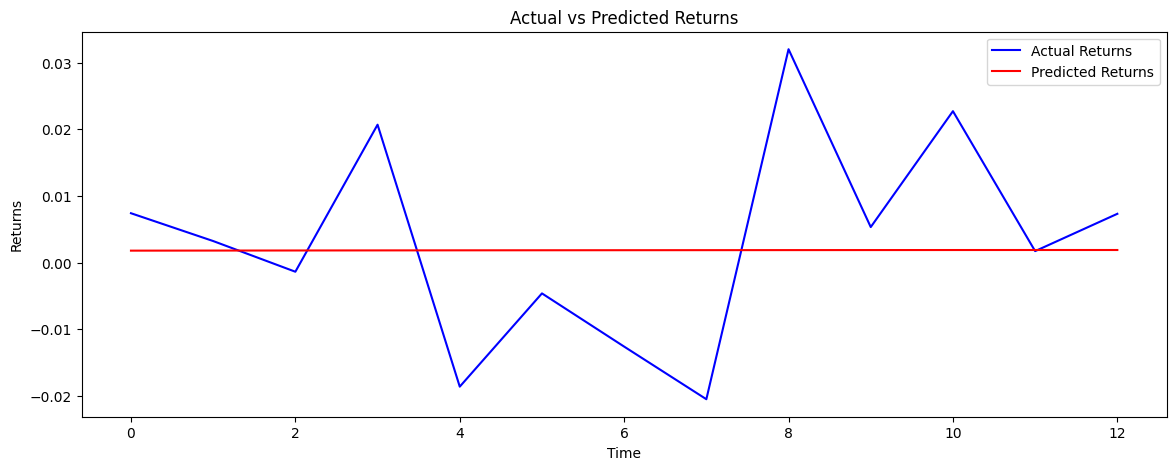

In [34]:
predictions_scaled = model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled).flatten()
y_test_unscaled = target_scaler.inverse_transform(y_test).flatten()

comp_df = pd.DataFrame({
    'Date': df[DATE_COL].values[test_beg + SEQ_LENGTH:test_end + SEQ_LENGTH + 1],
    'Actual': y_test_unscaled,
    'Predicted': predictions
})
print(tb.tabulate(comp_df, headers='keys', tablefmt='psql'))

mse = mean_squared_error(y_test_unscaled, predictions)
mae = mean_absolute_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R2: {r2:.3f}")

direction_correct = np.sum((np.sign(y_test_unscaled) == np.sign(predictions)).astype(int))
direction_accuracy = direction_correct / len(y_test_unscaled)
print(f"Direction Prediction Accuracy: {direction_accuracy * 100:.2f}%")

plt.figure(figsize=(14, 5))
plt.plot(y_test_unscaled, color='blue', label='Actual Returns')
plt.plot(predictions, color='red', label='Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()